Boilerplate imports

In [58]:
import datascience as ds
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

Get the data

In [59]:
# tip.csv is saved locally
data_path = 'C:/Users/Luke.Barger/Documents/Fall 2018/377/tips.csv'
tips_raw = ds.Table.read_table(data_path)
tips_raw

total_bill,tip,sex,smoker,day,time,size
16.99,1.01,Female,No,Sun,Dinner,2
10.34,1.66,Male,No,Sun,Dinner,3
21.01,3.5,Male,No,Sun,Dinner,3
23.68,3.31,Male,No,Sun,Dinner,2
24.59,3.61,Female,No,Sun,Dinner,4
25.29,4.71,Male,No,Sun,Dinner,4
8.77,2,Male,No,Sun,Dinner,2
26.88,3.12,Male,No,Sun,Dinner,4
15.04,1.96,Male,No,Sun,Dinner,2
14.78,3.23,Male,No,Sun,Dinner,2


## Look at some comparisons of tips by gender

Calculate mean tips for males and females

In [60]:
# Select rows for Males, extract tip array, calculate mean
male_tips=tips_raw.where('sex', ds.are.equal_to('Male'))
mean_male=np.mean(male_tips.column('tip'))
print('The average male tip is $',format(mean_male,'.2f'))

The average male tip is $ 3.09


In [61]:
female_tips=tips_raw.where('sex', ds.are.equal_to('Female'))
mean_female=np.mean(female_tips.column('tip'))
print('The average female tip is $',format(mean_female,'.2f'))

The average female tip is $ 2.83


Show histograms of male and female tips

Plot histograms of male and female tips

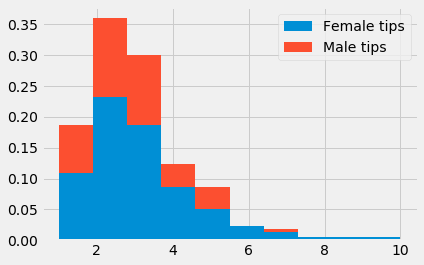

In [106]:
#first create a list - since there are an unqual number of male/female tips, can't create a table and just use .hist like in ds
plots.figure()
plots.hist([male_tips.column('tip'),female_tips.column('tip')],stacked=True,density=True)
plots.legend({'Male tips','Female tips'})

The male and female tips follow a similar distribution, but there are more male tips.  I can't really tell from this plot if one is systematically higher, although the higher mean on male tips suggests it is.

## Look at some comparisons of tips by 'time' (meal)

Calculate mean tips for different times

In [92]:
#First figure out what the 'times' are
tips_raw.group('time')

time,count
Dinner,176
Lunch,68


In [88]:
# Looks like it's just lunch and dinner
# Select rows for dinner, extract tip array, calculate mean
dinner_tips=tips_raw.where('time', ds.are.equal_to('Dinner'))
mean_dinner=np.mean(dinner_tips.column('tip'))
print('The average dinner tip is $',format(mean_dinner,'.2f'))

The average dinner tip is $ 3.10


In [93]:
# Select rows for lunch, extract tip array, calculate mean
lunch_tips=tips_raw.where('time', ds.are.equal_to('Lunch'))
mean_lunch=np.mean(lunch_tips.column('tip'))
print('The average lunch tip is $',format(mean_lunch,'.2f'))

The average lunch tip is $ 2.73


Plot histograms of male and female tips

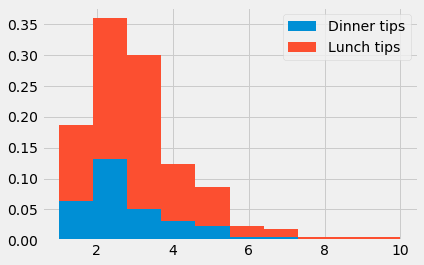

In [103]:
#first create a list - since there are an unqual number of lunch/dinner tips, can't create a table and just use .hist like in ds
plots.figure()
plots.hist([lunch_tips.column('tip'),dinner_tips.column('tip')],stacked=True,density=True)
plots.legend({'Lunch tips','Dinner tips'})

The lunch and dinner tips follow a similar distribution, but there are more dinner tips.  It is difficult to tell but dinner tips looks skewed higher.  It also has a much longer 'tail' towards higher tips, but that could be an outlier or just because there are a larger number of dinner entries.

Use a function to turn weekdays into numbers

In [109]:
#First let's see how the weekdays are written
tips_raw.group('day')

day,count
Fri,19
Sat,87
Sun,76
Thur,62


In [118]:
# Not all the days are represented in the data, but let's ignore that and make a general solution
def weekday_to_num(day_str):
    """ Take the weekday string and turn it into an integer.  
    
    Inputs are three char abbreviation of days of the week, except Thursday is 'Thur'
    
    Note per instructions the week starts at Mon = 1 
    because this takes place in some bizzare parallel reality.
    Also Sun = 7 just in case you thought we'd save things by indexing from 0 as if this were Python.
    """
    if day_str == 'Mon':
        day_num=1
    elif day_str == 'Tue':
        day_num=2
    elif day_str == 'Wed':
        day_num=3
    elif day_str == 'Thur':
        day_num=4
    elif day_str == 'Fri':
        day_num=5
    elif day_str == 'Sat':
        day_num=6
    elif day_str == 'Sun':
        day_num=7
    else:
        print('Inputs must be Mon, Tue, Wed, Thur, Fri, Sat, or Sun')
        day_num=0
    
    return day_num

In [127]:
# Apply weekday_to_num function column labeled 'day'
weekday=tips_raw.apply(weekday_to_num, 'day')
# Add this as new column labled 'weekday_num'
tips=tips_raw.with_column('weekday_num',weekday)
tips

total_bill,tip,sex,smoker,day,time,size,weekday_num
16.99,1.01,Female,No,Sun,Dinner,2,7
10.34,1.66,Male,No,Sun,Dinner,3,7
21.01,3.5,Male,No,Sun,Dinner,3,7
23.68,3.31,Male,No,Sun,Dinner,2,7
24.59,3.61,Female,No,Sun,Dinner,4,7
25.29,4.71,Male,No,Sun,Dinner,4,7
8.77,2,Male,No,Sun,Dinner,2,7
26.88,3.12,Male,No,Sun,Dinner,4,7
15.04,1.96,Male,No,Sun,Dinner,2,7
14.78,3.23,Male,No,Sun,Dinner,2,7


Some prediction of tips based on tips of similar total_bill.

In [142]:
def est_tip(bill,near=1):
    """Gives an estimate of a tip based on the total bill based on tips for other bills that are 'near'
    
    Finds entries where the total bill is within 'near' of 'bill' and returns the mean
    """
    similar_bills=tips.where('total_bill', ds.are.between(bill-near,bill+near))
    est=np.mean(similar_bills.column('tip'))
    return est

Apply this function to add a column of predicted tips to the tips table

In [146]:
est_tips=tips.apply(est_tip,'total_bill')
# Add this as a new column
tips=tips.with_column('Tip est',est_tips)
tips

total_bill,tip,sex,smoker,day,time,size,weekday_num,Tip est
16.99,1.01,Female,No,Sun,Dinner,2,7,2.82437
10.34,1.66,Male,No,Sun,Dinner,3,7,1.81136
21.01,3.5,Male,No,Sun,Dinner,3,7,3.3425
23.68,3.31,Male,No,Sun,Dinner,2,7,3.33867
24.59,3.61,Female,No,Sun,Dinner,4,7,3.56267
25.29,4.71,Male,No,Sun,Dinner,4,7,4.19909
8.77,2,Male,No,Sun,Dinner,2,7,1.865
26.88,3.12,Male,No,Sun,Dinner,4,7,3.48111
15.04,1.96,Male,No,Sun,Dinner,2,7,2.426
14.78,3.23,Male,No,Sun,Dinner,2,7,2.43833


Use a scatterplot to see how our estimate did (including how it tracks for different 'near' values)

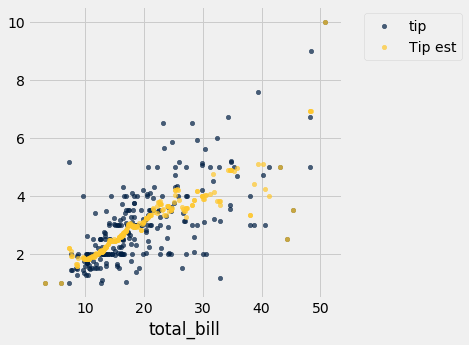

In [147]:
# Select columns with total bill, tip, estimated tip
tips.select('total_bill','tip','Tip est').scatter('total_bill')